In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training

# Load Files

In [ ]:
path = "PL_SC_1/"

In [2]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_PL_SC_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [3]:
len(windmill)

28

In [4]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [7]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [8]:
df = features.parallelize_extract(df)

parallelize_extract time:  1195.419908285141


In [9]:
df,ply_models_rn,_ = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,_ = features.extract_quantiles(df, "hws_uv_wsr")

In [14]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [15]:
feat = [x for x in df.columns if x not in cols_filter]
df = tools.normalize_features(df, feat)

In [16]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [17]:
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET"], "GSRN").reset_index(drop=True)

In [ ]:
len(df_train)

In [ ]:
df_train.to_csv(constant.PL_SC_TRAIN_path, index=False)
df_evl.to_csv(constant.PL_SC_EVL_path, index=False)

# Neural Network Train

In [ ]:
df_train = pd.read_csv(constant.PL_SC_TRAIN_path)

In [18]:
target = ["VAERDI"]
n_groups=5
lr=0.001
num_epochs=20
hidden_size = 1000
output_size = 1

## Original Features


In [46]:
cols = ['Capacity_kw','Navhub_height', 'Rotor_diameter', 
'wu10', 'wv10', 'wu100', 'wv100', 'tmp2', 'tmp100',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [21]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)
model_original, train_hist_original, test_hist_original = timeseries_kfold_validation_training(df=df_train, features=cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs, save_name=path+"original_model.pth")

Epoch 0 train loss: 0.06684426963329315 test loss: 0.050746433436870575
Epoch 10 train loss: 0.03670189529657364 test loss: 0.027597568929195404
Epoch 19 train loss: 0.030650772154331207 test loss: 0.032196853309869766
Epoch 0 train loss: 0.02992740273475647 test loss: 0.03207777440547943
Epoch 10 train loss: 0.026642024517059326 test loss: 0.021311646327376366
Epoch 19 train loss: 0.02520924247801304 test loss: 0.022945543751120567
Epoch 0 train loss: 0.024862073361873627 test loss: 0.02676161751151085
Epoch 10 train loss: 0.021372757852077484 test loss: 0.017164258286356926
Epoch 19 train loss: 0.020616473630070686 test loss: 0.01731264777481556
Epoch 0 train loss: 0.019963746890425682 test loss: 0.019397547468543053
Epoch 10 train loss: 0.018950508907437325 test loss: 0.019298236817121506
Epoch 19 train loss: 0.018599189817905426 test loss: 0.01929391175508499


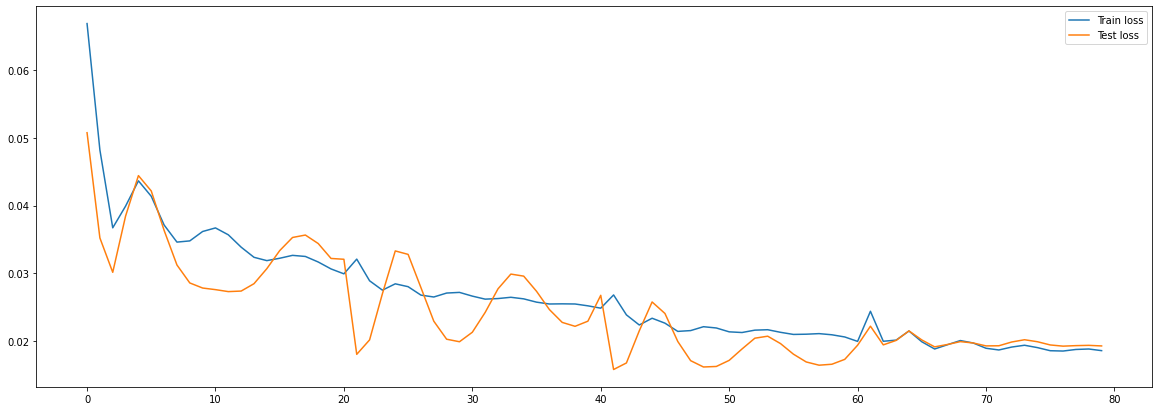

In [22]:
myplot.model_loss({"Train loss":train_hist_original, "Test loss": test_hist_original}, save_name=path+"original_loss.png")

## Windshear Features

In [49]:
cols = ['Capacity_kw','Navhub_height','Rotor_diameter',
'hws_u_wsr','hws_v_wsr','hws_uv_wsr','hws_uv_wsr^2','hws_uv_wsr^3','htmp_exp',
'hws_uv_wsr_q0.1','hws_uv_wsr_q0.3','hws_uv_wsr_q0.5','hws_uv_wsr_q0.7','hws_uv_wsr_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [26]:
model_wsr = MLP_Regression(
  input_size=50,
  hidden_size=hidden_size
)
model_wsr, train_hist_wsr, test_hist_wsr = timeseries_kfold_validation_training(df=df_train, features=cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs, save_name=path+"wsr_model.pth")

Epoch 0 train loss: 0.05062089115381241 test loss: 0.033553384244441986
Epoch 10 train loss: 0.01995743066072464 test loss: 0.016138892620801926
Epoch 19 train loss: 0.018410485237836838 test loss: 0.01781282015144825
Epoch 0 train loss: 0.017718566581606865 test loss: 0.015230641700327396
Epoch 10 train loss: 0.016060762107372284 test loss: 0.01766715571284294
Epoch 19 train loss: 0.014910943806171417 test loss: 0.01696881651878357
Epoch 0 train loss: 0.015148806385695934 test loss: 0.01408624928444624
Epoch 10 train loss: 0.013706989586353302 test loss: 0.009896459057927132
Epoch 19 train loss: 0.013106401078402996 test loss: 0.00983787514269352
Epoch 0 train loss: 0.012135999277234077 test loss: 0.011074715293943882
Epoch 10 train loss: 0.011767209507524967 test loss: 0.010792980901896954
Epoch 19 train loss: 0.011105053126811981 test loss: 0.011144018732011318


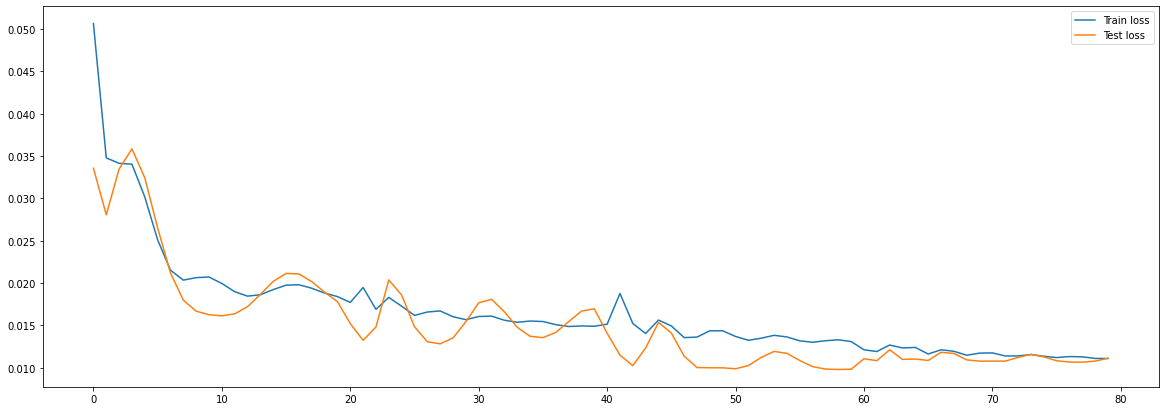

In [27]:
myplot.model_loss({"Train loss":train_hist_wsr, "Test loss": test_hist_wsr}, save_name=path+"wsr_loss.png")

## Geo Features

In [52]:
cols = ['Capacity_kw', 'Navhub_height', 'Rotor_diameter',
'Slope', 'Aspect', 
'hws_u_rn','hws_v_rn','hws_uv_rn','hws_uv_rn^2','hws_uv_rn^3','htmp_exp', 
'hws_uv_rn_q0.1','hws_uv_rn_q0.3','hws_uv_rn_q0.5','hws_uv_rn_q0.7','hws_uv_rn_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [31]:
model_geo = MLP_Regression(
  input_size=52,
  hidden_size=hidden_size
)
model_geo, train_hist_geo, test_hist_geo = timeseries_kfold_validation_training(df=df_train, features=cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs, save_name=path+"geo_model.pth")

Epoch 0 train loss: 0.06334452331066132 test loss: 0.046929314732551575
Epoch 10 train loss: 0.01749163493514061 test loss: 0.012595031410455704
Epoch 19 train loss: 0.010226918384432793 test loss: 0.00967028271406889
Epoch 0 train loss: 0.0099285077303648 test loss: 0.008534773252904415
Epoch 10 train loss: 0.010666892863810062 test loss: 0.01202856469899416
Epoch 19 train loss: 0.009573600254952908 test loss: 0.010369813069701195
Epoch 0 train loss: 0.010031299665570259 test loss: 0.012494939379394054
Epoch 10 train loss: 0.008878662250936031 test loss: 0.007520534098148346
Epoch 19 train loss: 0.008453411050140858 test loss: 0.007520425133407116
Epoch 0 train loss: 0.008098946884274483 test loss: 0.007032872177660465
Epoch 10 train loss: 0.008178077638149261 test loss: 0.007067442871630192
Epoch 19 train loss: 0.007791462354362011 test loss: 0.006809426937252283


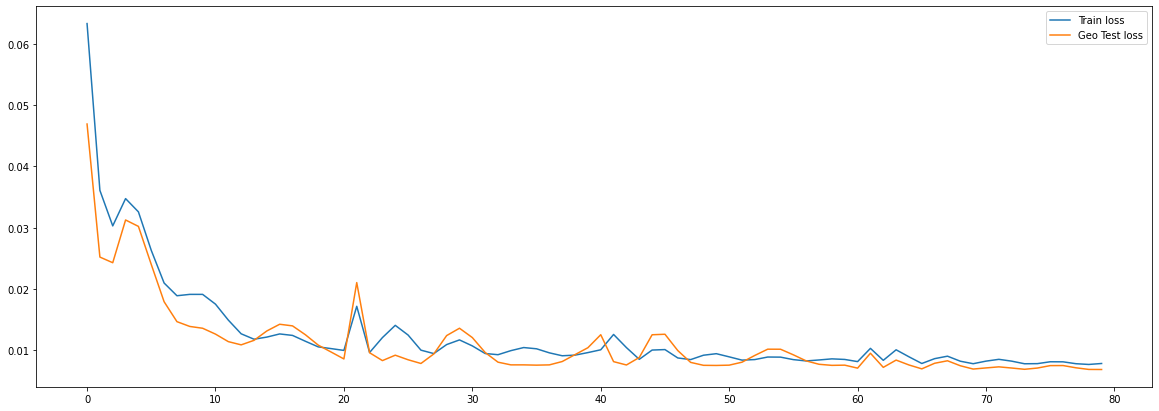

In [32]:
myplot.model_loss({"Train loss":train_hist_geo, "Geo Test loss": test_hist_geo}, save_name=path+"geo_loss.png")

## Semigeo Features

In [55]:
cols = ['Capacity_kw','Navhub_height', 'Rotor_diameter',
'Slope', 'Aspect', 'Roughness',
'hws_u_wsr','hws_v_wsr','hws_uv_wsr','hws_uv_wsr^2','hws_uv_wsr^3','htmp_exp', 
'hws_uv_wsr_q0.1','hws_uv_wsr_q0.3','hws_uv_wsr_q0.5','hws_uv_wsr_q0.7','hws_uv_wsr_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [36]:
model_semigeo = MLP_Regression(
  input_size=53,
  hidden_size=1000
)
model_semigeo, train_hist_semigeo, test_hist_semigeo = timeseries_kfold_validation_training(df=df_train, features=cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs, save_name=path+"semigeo_model.pth")

Epoch 0 train loss: 0.04037775471806526 test loss: 0.03247247636318207
Epoch 10 train loss: 0.01857829838991165 test loss: 0.016120340675115585
Epoch 19 train loss: 0.017811616882681847 test loss: 0.016006844118237495
Epoch 0 train loss: 0.017007991671562195 test loss: 0.013376097194850445
Epoch 10 train loss: 0.01623550057411194 test loss: 0.01755620166659355
Epoch 19 train loss: 0.015115568414330482 test loss: 0.01719718798995018
Epoch 0 train loss: 0.01510271430015564 test loss: 0.019049501046538353
Epoch 10 train loss: 0.013488773256540298 test loss: 0.010975576937198639
Epoch 19 train loss: 0.012756017968058586 test loss: 0.011346305720508099
Epoch 0 train loss: 0.01239667646586895 test loss: 0.01296587847173214
Epoch 10 train loss: 0.011511747725307941 test loss: 0.013484465889632702
Epoch 19 train loss: 0.011061253026127815 test loss: 0.013234150595963001


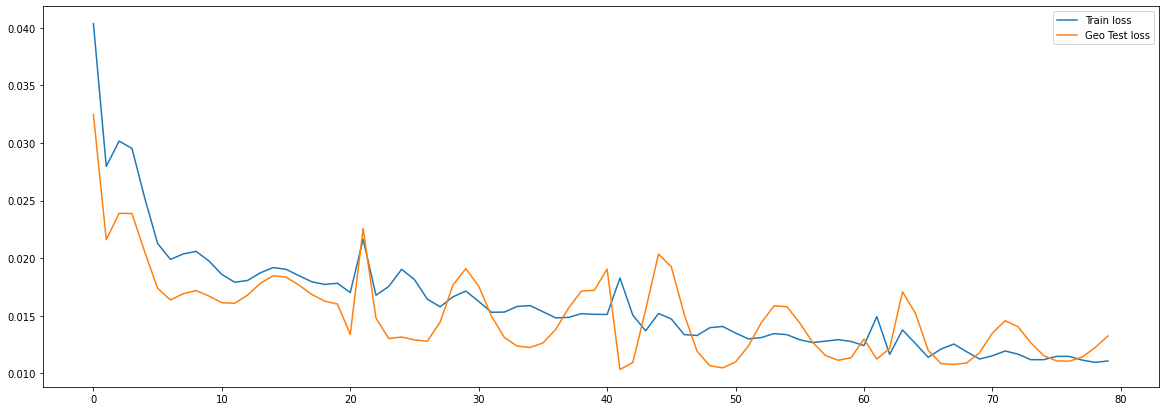

In [37]:
myplot.model_loss({"Train loss":train_hist_semigeo, "Geo Test loss": test_hist_semigeo}, save_name=path+"semigeo_loss.png")